In [2]:
#运行代码
import tracemalloc
import  anndata as ad
import time
from MSDnet import *
from find_anchor import *
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
torch.autograd.set_detect_anomaly(True)
base_path = r'D:\pythonplaces\deconv-mulST\Result\Dataset5'
start_time = time.time()
tracemalloc.start()
# 2. 拼接所有文件名（包括 st1 到 st17 + 最后一个特殊命名的文件）
file_names = [f"st{i}.h5ad" for i in range(1, 4)]
file_names.append("Sm_STdata_filter.h5ad")  # 加入第18个文件
file_paths = [os.path.join(base_path, fname) for fname in file_names]
datas = [ad.read_h5ad(fpath) for fpath in file_paths]

alldata = ad.read_h5ad('D:\pythonplaces\deconv-mulST\Result\Dataset5/all_data.h5ad')
alldata_scvi = ad.read_h5ad('D:\pythonplaces\deconv-mulST\Result\Dataset5/alldatas_scvi_ad.h5ad')

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
outdir = r'D:\pythonplaces\deconv-mulST\Result\Dataset5_1'
if not os.path.exists(outdir):
    os.makedirs(outdir)
modle = MSDnet(
    seed=40, device=device,
    adatas=datas, alldata=alldata, alldata_scvi=alldata_scvi,
    hidden_num_exp=512, output_num_exp=256,
    hidden_num_dis=512, output_num_dis=256,
    hidden_num_dec=128,
    latent_num_batch=128, batch_num=4,
    hidden_pre=256, cell_type_num=7,
    epochs=800, num_cluster=7, outdir=outdir
)

modle.train()
# result = modle.predicted_ST(outdir)
# result_path = os.path.join(outdir, "pre_labels.h5ad")
# result.write_h5ad(result_path)
# model_path = os.path.join(outdir, "model.pth")
# torch.save(modle.state_dict(), model_path)

end_time = time.time()  # 记录结束时间
total_time = end_time - start_time  # 计算总时间
print(f"Total time taken: {total_time:.2f} seconds")  # 打印总时间
current, peak = tracemalloc.get_traced_memory()
print(f"[Peak Memory] Current: {current / 1024 / 1024:.2f} MB; Peak: {peak / 1024 / 1024:.2f} MB")

cuda:0
============= Epoch 01/800 in stage =============
loss_stage1=1.324766, dis_loss=1.184385, rec_loss=16.999891,triple_loss=0.000000,pre_loss=3.027713
============= Epoch 21/800 in stage =============
loss_stage1=0.227078, dis_loss=1.171845, rec_loss=14.714336,triple_loss=0.000000,pre_loss=0.355176
============= Epoch 41/800 in stage =============
loss_stage1=0.133891, dis_loss=1.118545, rec_loss=14.394176,triple_loss=0.000000,pre_loss=0.148853
============= Epoch 61/800 in stage =============
loss_stage1=0.138142, dis_loss=0.950978, rec_loss=14.186165,triple_loss=0.491560,pre_loss=0.088692
============= Epoch 81/800 in stage =============
loss_stage1=0.123208, dis_loss=0.876714, rec_loss=13.956082,triple_loss=0.239973,pre_loss=0.062729
============= Epoch 101/800 in stage =============
loss_stage1=0.121139, dis_loss=0.942001, rec_loss=13.728597,triple_loss=0.696699,pre_loss=0.055126
============= Epoch 121/800 in stage =============
loss_stage1=0.156032, dis_loss=0.978725, rec_lo

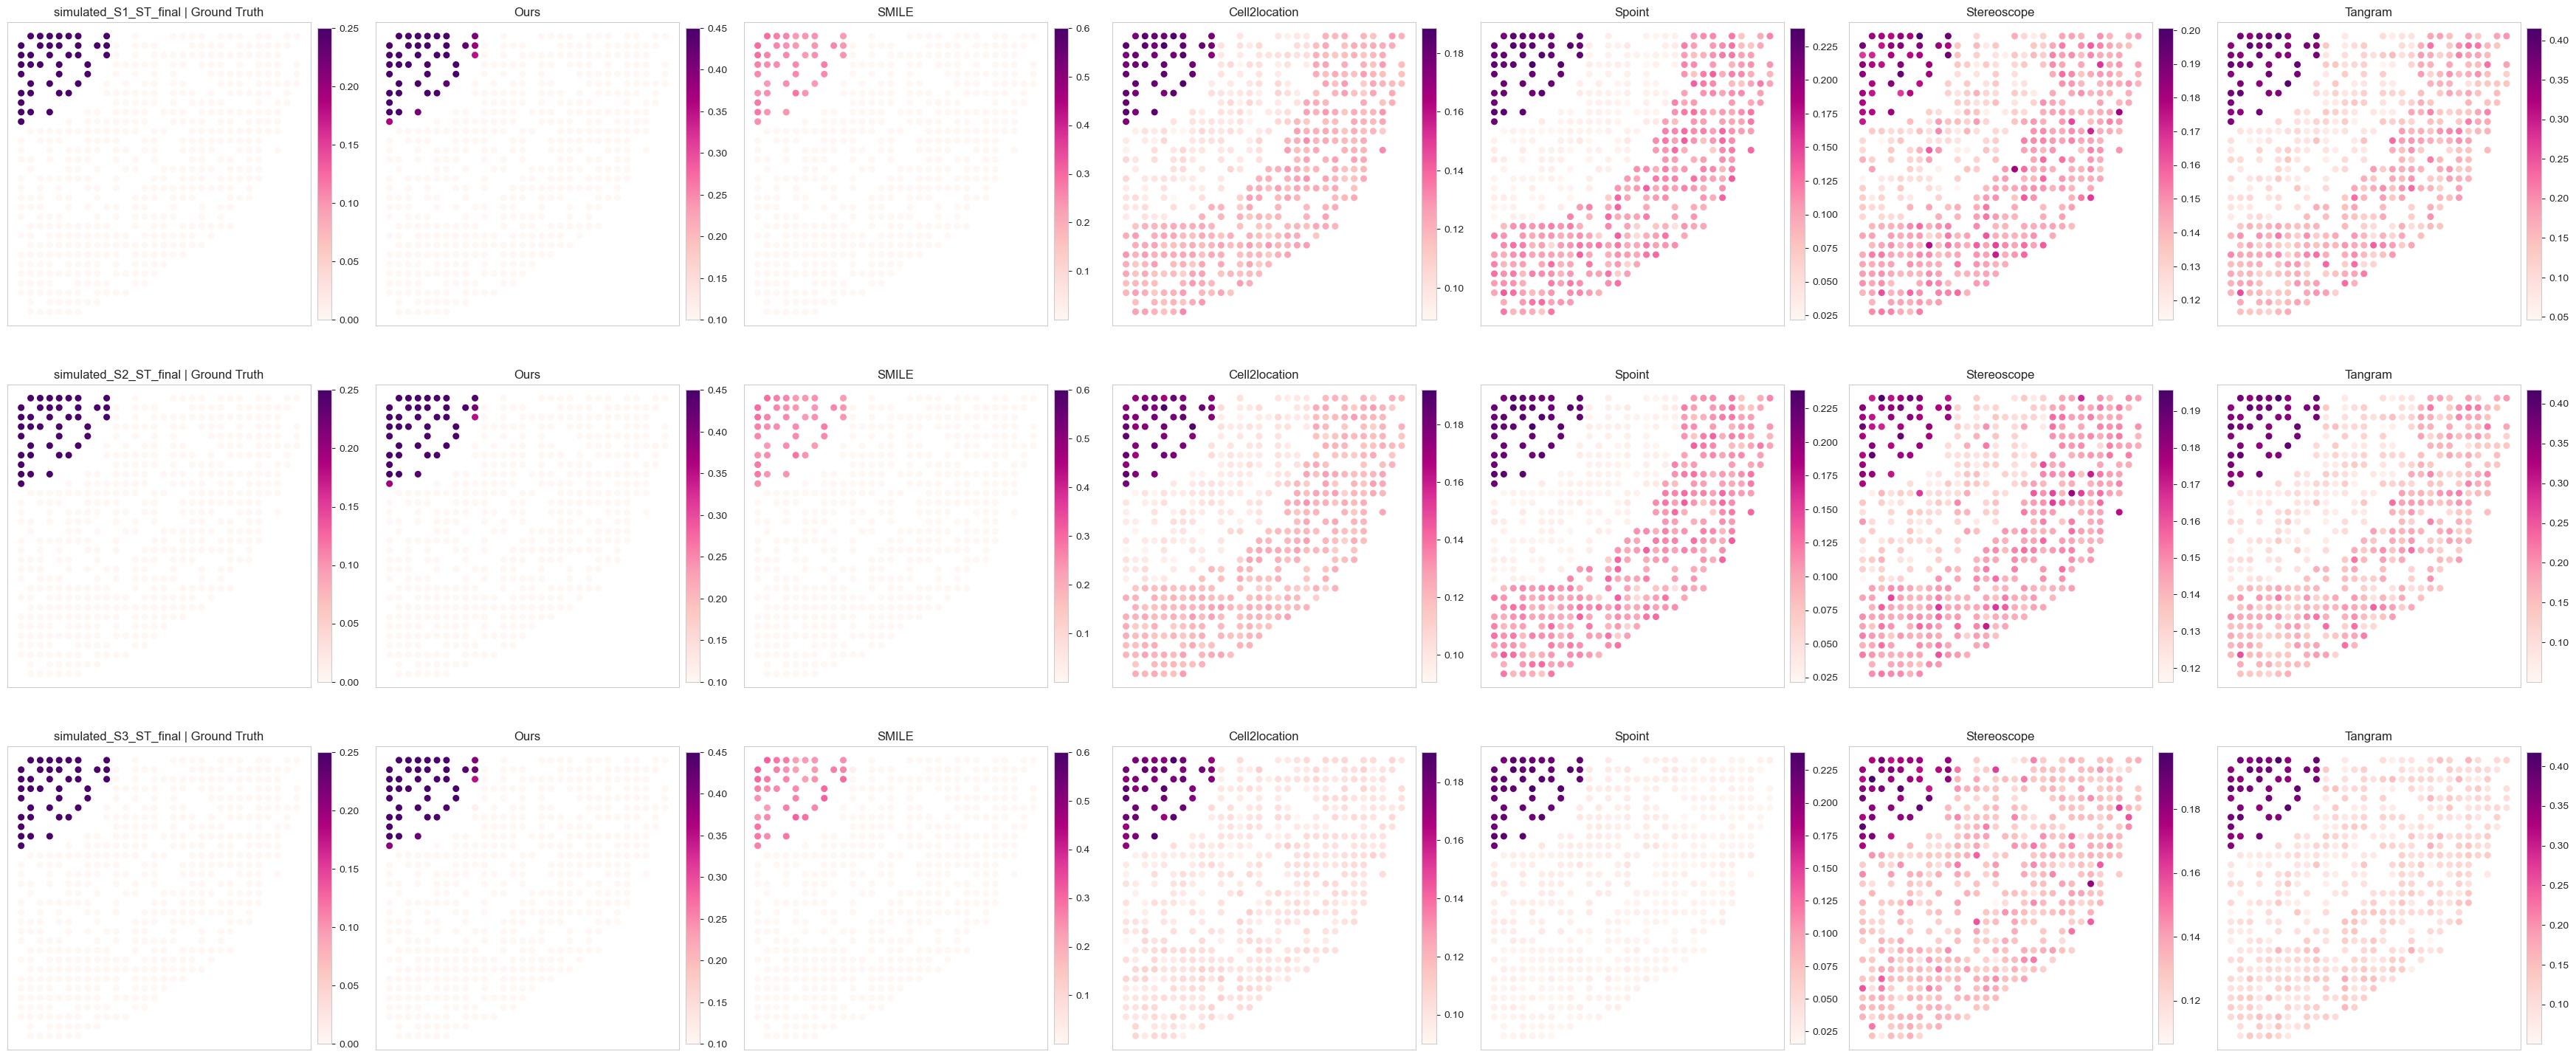

In [4]:
import re
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from pathlib import Path

# ========= 基础配置 =========
gt_files = [
    r"D:\pythonplaces\deconv-mulST\Dataset_origin\dataset5\simulated_S1_ST_final.h5ad",
    r"D:\pythonplaces\deconv-mulST\Dataset_origin\dataset5\simulated_S2_ST_final.h5ad",
    r"D:\pythonplaces\deconv-mulST\Dataset_origin\dataset5\simulated_S3_ST_final.h5ad",
]

methods = [
    {"title": "Ours",         "path": r"D:\pythonplaces\deconv-mulST\Result\dataset5\pre_labels.h5ad", "kind": "h5ad_deconv"},
    {"title": "SMILE",        "path": r"D:\pythonplaces\SMILE-main\SMILE\result\simulate_result.h5ad",           "kind": "smile"},
    {"title": "Cell2location","path": r"D:\pythonplaces\deconv-mulST\Baseline\Cell2location\Result\Dataset5\Cell2location_result2.csv", "kind": "csv"},
    {"title": "Spoint",       "path": r"D:\pythonplaces\deconv-mulST\Baseline\Spoint\Result\Dataset5\proportion1.csv",                   "kind": "csv"},
    {"title": "Stereoscope",  "path": r"D:\pythonplaces\deconv-mulST\Baseline\Stereoscope\Result\Dataset5\Stereoscope_result.csv",       "kind": "csv"},
    {"title": "Tangram",      "path": r"D:\pythonplaces\deconv-mulST\Baseline\Tangram\Result\Dataset5\Tangram_result.csv",               "kind": "csv"},
]

# 目标细胞类型（各方法尽量同名；GT/SMILE 若是数字列会自动映射）
target_celltype = "L2/3 IT"

# GT/SMILE 的数字列 → 细胞类型名 的映射
label_to_name = {
    "0": "L2/3 IT",
    "1": "L4",
    "2": "L5 IT",
    "3": "L5 PT",
    "4": "L6b",
    "5": "L6 CT",
    "6": "L6 IT",
}
#L2/3IT	L4	L5IT	L5PT	L6b	L6CT	L6IT
label_to_name_int = {int(k): v for k, v in label_to_name.items()}
name_to_label = {v: k for k, v in label_to_name.items()}

# ========= 每面板独立色标覆盖（你可在此随时加条目）=========
# 键可以是 (切片标题, 列标题)、('*', 列标题)、(切片标题, '*')
scale_overrides = {
    ('*', 'Ours'): {'vmin': 0.1, 'vmax': 0.45},      # 你要求的 Ours 全局范围
    ('*', 'SMILE'): {'vmax': 0.6},
}
# ===============================================

def _parse_suffix_from_gt(p: str) -> str:
    """从 GT 文件名解析切片编号，返回 '_k'（如 '_1'）。"""
    m = re.search(r"[Ss](\d+)", Path(p).stem)
    if not m:
        raise ValueError(f"无法从文件名解析切片编号: {p}")
    return f"_{int(m.group(1))}"

def _rename_numeric_cols_to_names(df: pd.DataFrame) -> pd.DataFrame:
    """若列是 0..6 或 '0'..'6'，映射为细胞类型名；否则不变。"""
    cols = list(df.columns)
    # 严格判断：列集合必须全在映射里（避免误改）
    if set(cols) and set(cols) <= set(label_to_name.keys()):
        return df.rename(columns=label_to_name)
    if set(cols) and set(cols) <= set(label_to_name_int.keys()):
        return df.rename(columns=label_to_name_int)
    return df

def _get_scale(slice_title: str, col_title: str):
    """按优先级获取该面板的 vmin/vmax： (切片, 列) > ('*', 列) > (切片, '*')。"""
    if (slice_title, col_title) in scale_overrides:
        return scale_overrides[(slice_title, col_title)]
    if ('*', col_title) in scale_overrides:
        return scale_overrides[('*', col_title)]
    if (slice_title, '*') in scale_overrides:
        return scale_overrides[(slice_title, '*')]
    return {}

# ---- 预读 SMILE（如存在）----
_smile_cached = None
if any(m["kind"] == "smile" for m in methods):
    ad = sc.read_h5ad(next(m["path"] for m in methods if m["kind"] == "smile"))
    smile_ad = ad
    smile_dec = ad.obsm['deconvolution']
    if not isinstance(smile_dec, pd.DataFrame):
        smile_dec = pd.DataFrame(smile_dec, index=ad.obs_names.astype(str))
    else:
        smile_dec.index = smile_dec.index.astype(str)
    smile_dec = _rename_numeric_cols_to_names(smile_dec)
    if 'slice_name' not in ad.obs.columns:
        raise KeyError("SMILE 数据缺少 obs['slice_name']")
    smile_slice_name = ad.obs['slice_name'].astype(str).values  # 'S1'/'S2'/'S3'
    _smile_cached = (smile_ad, smile_dec, smile_slice_name)

# ---------- 主循环组装画布数据 ----------
rows_data = []  # 每行（切片）: coords, vals, col_titles
if target_celltype not in name_to_label:
    raise KeyError(f"映射中缺少 '{target_celltype}'，请在 label_to_name 中补充。")
gt_col_label = name_to_label[target_celltype]  # 如 '2'

for gt_path in gt_files:
    suffix = _parse_suffix_from_gt(gt_path)  # '_1' / '_2' / '_3'
    s_label = f"S{suffix[-1]}"               # 'S1' / 'S2' / 'S3'
    adata = sc.read_h5ad(gt_path)

    base_index = adata.obs_names.astype(str)
    coords = pd.DataFrame(adata.obsm["spatial"], index=base_index, columns=["x", "y"])

    # GT: obsm['proportion'] 的数字列
    prop = adata.obsm["proportion"]
    if not isinstance(prop, pd.DataFrame):
        prop = pd.DataFrame(prop, index=base_index, columns=[str(i) for i in range(prop.shape[1])])
    else:
        prop.index = base_index
        prop.columns = prop.columns.astype(str)
    if gt_col_label not in prop.columns:
        raise KeyError(f"GT proportion 不含列 '{gt_col_label}'；现有列示例：{list(prop.columns)[:10]}")
    gt_vals = prop[gt_col_label].to_numpy().ravel()

    col_vals = [gt_vals]
    col_titles = ["Ground Truth"]

    for m in methods:
        title, path, kind = m["title"], m["path"], m["kind"]
        col_titles.append(title)

        try:
            if kind == "smile":
                # 仅按切片筛选 + 长度校验，不做索引对齐
                smile_ad, smile_dec, smile_slice_name = _smile_cached
                mask = (smile_slice_name == s_label)
                smile_slice = smile_dec.loc[smile_ad.obs_names[mask].astype(str)]
                if target_celltype not in smile_slice.columns:
                    print(f"[提示] SMILE 缺少列 '{target_celltype}'；可用列示例：{list(smile_slice.columns)[:10]} ... 将置空")
                    col_vals.append(None)
                else:
                    v = smile_slice[target_celltype].to_numpy().ravel()
                    if len(v) != len(base_index):
                        print(f"[提示] SMILE({s_label}) 与 GT({Path(gt_path).stem}) 长度不一致：{len(v)} vs {len(base_index)}，已跳过该面板")
                        col_vals.append(None)
                    else:
                        col_vals.append(v)

            elif kind == "h5ad_deconv":
                ad = sc.read_h5ad(path)
                df = ad.uns.get("deconv_result")
                if not isinstance(df, pd.DataFrame):
                    df = pd.DataFrame(df)
                df.index = df.index.astype(str)
                # 取对应切片，去后缀，与 GT 对齐
                df_slice = df[df.index.str.endswith(suffix)].copy()
                df_slice.index = df_slice.index.str.replace(r"_\d+$", "", regex=True)
                aligned = df_slice.reindex(base_index)
                if target_celltype in aligned.columns:
                    col_vals.append(aligned[target_celltype].to_numpy().ravel())
                else:
                    print(f"[提示] {Path(path).name} 缺少列 '{target_celltype}'；可用列示例：{list(aligned.columns)[:10]} ... 将置空")
                    col_vals.append(None)

            elif kind == "csv":
                df = pd.read_csv(path, index_col=0)
                df.index = df.index.astype(str)
                df_slice = df[df.index.str.endswith(suffix)].copy()
                df_slice.index = df_slice.index.str.replace(r"_\d+$", "", regex=True)
                aligned = df_slice.reindex(base_index)
                if target_celltype in aligned.columns:
                    col_vals.append(aligned[target_celltype].to_numpy().ravel())
                else:
                    print(f"[提示] {Path(path).name} 缺少列 '{target_celltype}'；可用列示例：{list(aligned.columns)[:10]} ... 将置空")
                    col_vals.append(None)

            else:
                print(f"[提示] 未知 kind: {kind}，已置空")
                col_vals.append(None)

        except Exception as e:
            print(f"[跳过] 读取失败 {title} ({path}) -> {e}")
            col_vals.append(None)

    rows_data.append({
        "title": Path(gt_path).stem,
        "coords": coords,
        "vals": col_vals,
        "col_titles": col_titles,
    })

# ---------- 画图（每面板独立色标 + 各自 colorbar） ----------
n_rows = len(rows_data)
n_cols = len(rows_data[0]["col_titles"])

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
if n_rows == 1:
    axes = np.array([axes])

for r, row in enumerate(rows_data):
    coords = row["coords"]
    vals = row["vals"]
    titles = row["col_titles"]
    slice_title = row["title"]

    for c in range(n_cols):
        ax = axes[r, c]
        v = vals[c]
        title = titles[c]

        if v is None:
            ax.set_title(f"{title}\n(缺/跳过)")
            ax.axis("off")
            continue

        scale = _get_scale(slice_title, title)  # 读取该面板的 vmin/vmax（未设则自适应）
        sca = ax.scatter(
            coords["x"], coords["y"],
            c=v, cmap="RdPu", s=30,
            **({k: scale[k] for k in ('vmin', 'vmax') if k in scale})
        )
        fig.colorbar(sca, ax=ax, orientation='vertical', fraction=0.045, pad=0.02)

        # 首列额外带上切片名
        if c == 0:
            ax.set_title(f"{slice_title} | {title}", fontsize=12)
        else:
            ax.set_title(title, fontsize=12)

        ax.set_aspect("equal")
        ax.invert_yaxis()
        ax.set_xticks([]); ax.set_yticks([])

plt.tight_layout()
# plt.savefig("D:/pythonplaces/deconv-mulST/img/Dataset5/L2_3_IT.pdf", format="pdf", bbox_inches="tight", dpi=300)
plt.show()